<a href="https://colab.research.google.com/github/YusukeAoki57/diveintocode-ml/blob/master/sprint_CNN_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
X_train=X_train.reshape(-1,1,X_train.shape[1],X_train.shape[2])
X_test=X_test.reshape(-1,1,X_test.shape[1],X_test.shape[2])
X_test.shape

(10000, 1, 28, 28)

In [4]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [5]:
#問題1
class Conv2d:
    def __init__(self,W,B,optimizer,filter_size=3,stride=1,pading=0,filter_num=30):
      self.optimizer = optimizer
      self.h_filter_size=filter_size
      self.w_filter_size=filter_size
      self.filter_num=filter_num
      self.W = W
      self.B = B
      self.stride_h=stride
      self.stride_w=stride
      self.pading_h=pading
      self.pading_w=pading
      

    #forward  
    def forward(self,X):
      n_h_out,n_w_out=self._n_out(X)
      #print("nh"+str(n_h_out))
      #print(X.shape[1])

      a=np.zeros((X.shape[0],self.filter_num,n_h_out,n_w_out)) #aの初期化
      #print(a[1])
      for b in range(X.shape[0]):#バッチサイズ
        for m in range(self.filter_num):#出力チャネル数 
          for i in range(n_h_out): #出力後の高さのインデックス数
            for j in range(n_w_out):#出力後の幅のインデックス数
              for s in range(self.h_filter_size): #高さ方向のフィルタサイズ
                for t in range(self.w_filter_size):#幅方向のフィルタサイズ
                  a[b][m][i][j]=a[b][m][i][j]+X[b][0][i+s][j+t]*self.W[s][t][0][m]
                
          a[b][m]+self.B[m]
      return a
    #backward
    #dW
    def backward(self,dA,X):
      #print(dA.shape)
      #print(X.shape)
      n_h_out,n_w_out=self._n_out(dA)
      dW=np.zeros((self.h_filter_size,self.w_filter_size,X.shape[0],self.filter_num))
      for b in range(X.shape[0]):#バッチサイズ
        for m in range(self.filter_num):#出力チャネル数 
          for i in range(n_h_out): #出力後の高さのインデックス数
            for j in range(n_w_out):#出力後の幅のインデックス数
              for k in range(X.shape[1]): #入力層のチャネル数
                for s in range(self.h_filter_size): #高さ方向のフィルタサイズ
                  for t in range(self.w_filter_size):#幅方向のフィルタサイズ
                    dW[s][t][k][m]=dW[s][t][k][m]+dA[b][m][i][j]*X[b,k,i+s,j+t] 
      
      #bias  
      dB=np.zeros((self.filter_num)) 
      for b in range(X.shape[0]):#バッチサイズ  
        for m in range(self.filter_num):#出力チャネル数 
          for i in range(n_h_out): #出力後の高さのインデックス数
            for j in range(n_w_out):#出力後の幅のインデックス数
              dB[m]=dB[m]+dA[b][m][i][j]
        
      #dX
      dX=np.zeros((X.shape[0],n_h_out,n_w_out,X.shape[1]))
      for b in range(X.shape[0]):#バッチサイズ
        for m in range(self.filter_num):#出力チャネル数 
          for i in range(n_h_out): #出力後の高さのインデックス数
            for j in range(n_w_out):#出力後の幅のインデックス数
              for k in range(X.shape[1]): #入力層のチャネル数
                for s in range(self.h_filter_size): #高さ方向のフィルタサイズ
                  for t in range(self.w_filter_size):#幅方向のフィルタサイズ
                    dX[b][i][j][k]=dX[b][i][j][k]+dA[b][m][i-s][j-t]*self.W[s][t][k][m]

      self.W,self.B=self.optimizer.update(self.W,self.B,dW,dB)
      return self.W,self.B,dX

      
    #問題2
    def _n_out(self,X):
      n_h_out=(X.shape[2]+2*self.pading_h-self.h_filter_size)/self.stride_h+1
      n_w_out=(X.shape[3]+2*self.pading_w-self.w_filter_size)/self.stride_w+1
      return int(n_h_out),int(n_w_out)


(1, 1, 4, 4)
(3, 3, 1, 2)


IndexError: ignored

In [31]:
#問題3
class MaxPool2D:
  def __init__(self,optimizer,batch_size, A ,filter_size=3,stride=1,pading=0,filter_num=30):
    self.optimizer = optimizer
    self.h_filter_size=filter_size
    self.w_filter_size=filter_size
    self.filter_num=filter_num
    self.stride_h=stride
    self.stride_w=stride
    self.pading_h=pading
    self.pading_w=pading
    self.batch_size=batch_size
    self.H=np.zeros((A.shape[0],A.shape[1],A.shape[2],A.shape[3]))
  def forward(self, A):
    n_h_out,n_w_out=self._n_out(A)
    pool_a=np.zeros((A.shape[0],self.filter_num,n_h_out,n_w_out)) #pool値の初期化
    index1=None
    index2=None
    index3=None
    index4=None
    
    for b in range(A.shape[0]):#バッチサイズ
      for m in range(self.filter_num):#出力チャネル数
        for i in range(n_h_out):#高さの出力サイズ
          for j in range(n_w_out):#幅の出力サイズ
            for c1 in range(self.h_filter_size):#高さ方向のチェック
              for c2 in range(self.w_filter_size):#幅方向のチェック
                if A[b][m][i][j]>=A[b][m][i+c1][j+c2]:
                  max_a=A[b][m][i][j]
                  index1=b
                  index2=m
                  index3=i
                  index4=j
                elif A[b][m][i][j]<A[b][m][i+c1][j+c2]:
                  max_a=A[b][m][i+c1][j+c2]                    
                  index1=b
                  index2=m
                  index3=i
                  index4=j
            self.H[index1][index2][index3][index4]='555'
            pool_a[b][m][i][j]=max_a
    return pool_a

  def backward(self,d,A):
    n_h_out,n_w_out=self._n_out(A)
    A=np.zeros((A.shape[0],A.shape[1],A.shape[2],A.shape[3]))
    for b in range(A.shape[0]):#バッチサイズ
      for m in range(self.filter_num):#出力チャネル数
        for i in range(d.shape[2]):#高さの出力サイズ
          for j in range(d.shape[3]):#幅の出力サイズ
            if self.H[b][m][i][j]=='555':
              A[b][m][i][j]=d[b][m][i][j] 
    return A

  def _n_out(self,X):
    n_h_out=(X.shape[2]+2*self.pading_h-self.h_filter_size)/self.stride_h+1
    n_w_out=(X.shape[3]+2*self.pading_w-self.w_filter_size)/self.stride_w+1
    return int(n_h_out),int(n_w_out)     


In [8]:
#問題5
class Flatten:
   def __init__(self,X):
       self.s0=X.shape[0]
       self.s1=X.shape[1]
       self.s2=X.shape[2]
       self.s3=X.shape[3]
   def forward(self,X):
       A=X.flatten()
       s=self.s1*self.s2*self.s3
       A=A.reshape(self.s0,s)
       return A,s
   def backward(self,X):
       X=X.reshape(self.s0,self.s1,self.s2,self.s3)
       return X

In [27]:
#問題6

class ScratchDeepCNNClassifier:
    def __init__(self, batch_size = 20,init='Simple',ac='Tanh',opt='SGD', seed=0,filter_num=30):
        self.batch_size=batch_size
        self.n_features=784
        self.n_nodes1=400
        self.n_nodes2=200
        self.n_output=10
        self.sigma=0.1
        self.init=init
        self.ac=ac
        self.opt=opt
        self.W1=None
        self.W2=None
        self.W3=None
        self.B1=None
        self.B2=None
        self.B3=None
        self.fanction=None
        self.optimizer=None
        self.filter_size=3
        self.pading=0
        self.stride=1
        self.filter_num=filter_num

    def _initializer(self,X):
      if self.init=='Simple':
        self.W1 = self.sigma * np.random.randn(self.filter_size,self.filter_size,X.shape[1],self.filter_num) #conv2d
        #faltten   
        
        self.W3=SimpleInitializer(self.sigma).W(self.n_nodes2,self.n_output) #(200,10)
        self.B1=self.sigma * np.random.randn(self.filter_num)
        self.B2=SimpleInitializer(self.sigma).B(self.n_nodes2)
        self.B3=SimpleInitializer(self.sigma).B(self.n_output)
        
      elif self.init=='Xavier':
        self.sigma = math.sqrt(1 / self.filter_size)
        self.W1 = self.sigma * np.random.randn(self.filter_size,self.filter_size,self.filter_num,X.shape[1])
        self.W2=He().W(self.n_nodes1,self.n_nodes2)
        self.W3=He().W(self.n_nodes2,self.n_output)
        self.sigma = math.sqrt(1 / self.filter_size)
        self.B1 = self.sigma * np.random.randn(self.filter_num)
        self.B2=He().B(self.n_nodes1,self.n_nodes2)
        self.B3=He().B(self.n_nodes2,self.n_output)
      
      elif self.init=='He':
        self.n_nodes1=self._n_out(X)
        self.sigma = math.sqrt(2 / self.filter_size)
        self.W1 = self.sigma * np.random.randn(self.filter_size,self.filter_size,self.filter_num,X.shape[1])
        self.W2=He().W(self.n_nodes1,self.n_nodes2)
        self.W3=He().W(self.n_nodes2,self.n_output)
        self.sigma = math.sqrt(2 / self.filter_size)
        self.B1 = self.sigma * np.random.randn(self.filter_num)
        self.B2=He().B(self.n_nodes1,self.n_nodes2)
        self.B3=He().B(self.n_nodes2,self.n_output)


    def fit(self, X,y):
        
        if self.ac=='Tanh':
          self.fanction=Tanh()
        elif self.ac=='ReLU':
          self.fanction=ReLU()
        else:
          self.fanction=Sigmoid()

        if self.opt=='SGD':
          self.optimizer=SGD()
        else:
          self.optimizer=AdaGrad()


        n_epochs = 2
        #n_step_iteration_report = 384
        plot_data = []
        Loss=[]
        Val_loss=[]
        Epoch=[]
        self.X=X
        self.y=y
        new_loss=[]       
        #y_val = y_val.reshape(-1, 1) == np.arange(10)
        self._initializer(X)
        for epoch in range(n_epochs):
            for i, (x, y) in enumerate(GetMiniBatch(self.X,self.y,self.batch_size)):
              #forword
              y = y.reshape(-1, 1) == np.arange(10)
              y=y.reshape(y.shape[0],10)
              
              self.Conv1 = Conv2d(self.W1,self.B1,self.optimizer).forward(x)
              self.Pool = MaxPool2D(self.optimizer,self.batch_size,self.Conv1,filter_size=3,stride=1,pading=0,filter_num=30).forward(self.Conv1)
              self.flat,s=Flatten(self.Pool).forward(self.Pool) #(20,s)
              if epoch==0 and i==0:
                self.W2=SimpleInitializer(self.sigma).W(s,self.n_nodes2)
              self.activation1 = self.fanction.forward(self.flat) #(20,s)
              self.FC1 = FC(self.W2,self.B2,self.optimizer).forward(self.activation1) #(20,200)              
              self.activation2 = self.fanction.forward(self.FC1)
              self.FC2 = FC(self.W3,self.B3,self.optimizer).forward(self.activation2) #(20,10)
              self.activation3 = Softmax(self.batch_size).forward(self.FC2) #(20,10) 
              self.loss=Softmax(self.batch_size).loss(self.activation3,y) 
              #backword
              self.dloss=Softmax(self.batch_size).backward(self.activation3,y) #(20,10)
              self.W3,self.B3,self.dZ2 = FC(self.W3,self.B3,self.optimizer).backward(self.dloss,self.activation2) #(20,10)*(20,200)=(200,10)
              self.dactivation2 = self.fanction.backward(self.dZ2, self.activation2) #(20,200)
              self.W2,self.B2,self.dZ1 = FC(self.W2,self.B2,self.optimizer).backward(self.dactivation2,self.activation1) #(200,20)*(20,200)=(200,200)
              self.dactivation1 = self.fanction.backward(self.dZ1,self.activation1) #(20,s)
              self.dflat=Flatten(self.Pool).backward(self.dactivation1) #(20,チャネル数,h,w)
              self.dpool=MaxPool2D(self.optimizer,self.batch_size,self.Conv1,filter_size=3,stride=1,pading=0,filter_num=30).backward(self.dflat,self.Conv1) #(20,出力c,h,w)
              self.W1,self.B1,self.dX = Conv2d(self.W1,self.B1,self.optimizer).backward(self.dpool,x) #(X.shape) 
              Loss.append(self.loss)
              print(str(i)+"回目")
            new_loss.append(np.mean(Loss))
            Loss=[] 
            print(new_loss)
            Epoch.append(epoch)
        plt.plot(Epoch, new_loss, color='r', label='train_loss')
        #plt.plot(Epoch, Val_loss, color='b', label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
      
    def predict(self,x):
        self.Conv1 = Conv2d(self.W1,self.B1,self.optimizer).forward(x)
        self.Pool = MaxPool2D(self.optimizer,self.batch_size,self.Conv1,filter_size=3,stride=1,pading=0,filter_num=30).forward(self.Conv1)
        self.flat,s=Flatten(self.Pool).forward(self.Pool) #(20,s)
        self.activation1 = self.fanction.forward(self.flat) #(20,s)
        self.FC1 = FC(self.W2,self.B2,self.optimizer).forward(self.activation1) #(20,200)              
        self.activation2 = self.fanction.forward(self.FC1)
        self.FC2 = FC(self.W3,self.B3,self.optimizer).forward(self.activation2) #(20,10)
        self.activation3 = Softmax(self.batch_size).forward(self.FC2) #(20,10)  
        result=self.activation3.argmax(axis=1)
        return result


In [10]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self,W,B,optimizer,batch_size=20):
        #重みの初期化
        self.W=W
        self.B=B
        self.optimizer=optimizer
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        
        A=np.dot(X,self.W)+self.B 
        #(20,s),(s,200)=(20,200)
        #(20,200)*(200,10)=(20,10)
        return A
    def backward(self,dactivation,X):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dB=np.sum(dactivation,axis=0) 
        dW=np.dot(X.T,dactivation)
        #(200,20)*(20,10)=(200,10)
        #(s,20)*(200,10)
        dZ=np.dot(dactivation,self.W.T) 
        #(20,10)*(10,200)=(20,200)
        self.W,self.B=self.optimizer.update(self.W,self.B,dW,dB)
        return self.W,self.B,dZ

    def backward2(self,X,dactivation):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dB=np.sum(dactivation,axis=0) #(1,10)
        print(dB.shape)
        dW=np.dot(X.T,dactivation) 
        #(20,10)*(20,400)=(784,400)
        #print(dW.shape)
        self.W,self.B=self.optimizer.update(self.W,self.B,dW,dB)
        return self.W,self.B


In [11]:
class Tanh:
      def forward(self,X):
        Z=np.tanh(X)
        return Z
      def backward(self,X,activation):
        dA=X*(1-activation**2)
        return dA

In [12]:
class Softmax:
      def __init__(self,batch_size=20):
        self.batch_size=batch_size
      def forward(self,X):
        log_z3 = np.log(np.exp(X)) - self._logsumexp(X) #(20,10)
        self.Z3 = np.exp(log_z3) #(20,10)
        return self.Z3
      def _logsumexp(self,X):
        xmax = np.max(X,axis=1)
        xmax=xmax.reshape(X.shape[0],1)
        return np.log(np.exp(X - xmax).sum(axis=1, keepdims=True)) + xmax
      def loss(self,X,y):
        L=-np.sum(np.sum(y*np.log(X),axis=1),axis=0)/self.batch_size 
        return L
      def backward(self,L,y):
        dA3=(L-y)/self.batch_size #(20,10)
        return dA3

In [13]:
class SimpleInitializer:
      def __init__(self, sigma=0.01):
        self.sigma = sigma
      def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        
        self.W = self.sigma * np.random.randn(n_nodes1,n_nodes2)    
        return self.W
      def B(self, n_nodes):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        #バイアス項の初期値
        sigm=0.01
        self.B=self.sigma * np.random.randn(n_nodes,)
        return self.B


In [14]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self,W,B,dW,dB):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        W=W-self.lr*dW
        B=B-self.lr*dB

        return W,B
        
        

In [15]:
class ReLU:
   def forward(self,A):
     return np.clip(A, 0, None)
    
   def backward(self,dZ, A):
     return dZ * np.clip(np.sign(A), 0, None)

In [16]:
import math
class XavierInitializer:
  def W(self, n_nodes1, n_nodes2):
      self.sigma = math.sqrt(1 / n_nodes1)
      W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
      return W
  def B(self, n_nodes1,n_nodes2):
      self.sigma = math.sqrt(1 / n_nodes1)
      B = self.sigma * np.random.randn(n_nodes2)
      return B

In [17]:
import math
class He:
  def W(self, n_nodes1, n_nodes2):
      self.sigma = math.sqrt(2 / n_nodes1)
      W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
      return W
  def B(self, n_nodes1,n_nodes2):
      self.sigma = math.sqrt(2 / n_nodes1)
      B = self.sigma * np.random.randn(n_nodes2)
      return B

In [18]:
class AdaGrad:
    
    def __init__(self, lr=0.01):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    
    def update(self,W,B,dW,dB):
        self.HW += dW**2
        self.HB += dB**2
        W -= self.lr * np.sqrt(1/self.HW) * dW
        B -= self.lr * np.sqrt(1/self.HB) * dB
        self.HW=1
        self.HB=1
        return W,B

In [19]:
class Sigmoid:
    
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    
    def backward(self, dZ, A):
        self.A=A
        _sig = self.sigmoid(self.A) #(20,200)
        return dZ * (1 - _sig)*_sig #(200,10)*(20,200)
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

0回目
1回目
[2.59548394944436]
0回目
1回目
[2.59548394944436, 2.119340582823063]


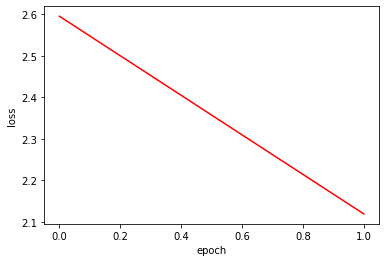

In [32]:
scnn=ScratchDeepCNNClassifier()
scnn.fit(X_train[0:40],y_train)

In [33]:
y_pred=scnn.predict(X_test[0:20])
np.unique(y_pred)

array([1, 2, 3, 4, 5, 6, 7])

In [37]:
#Accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test[0:20], y_pred))

0.2
